<a href="https://colab.research.google.com/github/YOUbhrt/DL-PROJECT-Skin-Lesions-Classification-with-Deep-Convolutional-Neural-Network/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


**Load the Data from Kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"younesbouhribat","key":"14db9210ac7edc3c5d4e52aefcabf378"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "nodoubttome/skin-cancer9-classesisic"


kaggle.json
 99% 781M/786M [00:10<00:00, 72.0MB/s]
100% 786M/786M [00:10<00:00, 79.5MB/s]


In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

**Data Direction**

Extract Train and Test files direction

In [ ]:
DATADIR_Train = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
DATADIR_Test = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

Extract the categories of skin lession

In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATADIR_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['pigmented benign keratosis', 'squamous cell carcinoma', 'seborrheic keratosis', 'melanoma', 'vascular lesion', 'basal cell carcinoma', 'nevus', 'dermatofibroma', 'actinic keratosis']


Now let's divide the data Train and Test to X and Y(label).

In [ ]:

x_train_data = []
y_train_data = []
IMG_SIZE=224
def create_training_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
create_training_data()

In [ ]:

x_test_data = []
y_test_data = []
IMG_SIZE=224
def create_testing_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
create_testing_data()

Split the Train DATA to Train and Validation, and show the shape of eache X and Y data.

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=1)

Reshape the Dataset

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
X_Train.shape

(2015, 224, 224, 3)

In [ ]:
Y_Train.shape

(2015,)

In [ ]:
x_test_data.shape

(118, 224, 224, 3)

In [ ]:
X_Val.shape

(224, 224, 224, 3)

In [ ]:
Y_Val.shape

(224,)

To launch the Train we need to make categories from Y_Train and X_Val.

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [ ]:
Y_Train.shape

(2015, 9)

In [ ]:
Y_Val.shape

(224, 9)

# **Show the data**

In [ ]:
from random import shuffle
def create_data(CATEGORIES, DATADIR):
  data = []
  for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    #class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        data.append([img_array, category])
      except Exception as e:
          pass
  shuffle(data)
  return data


In [ ]:
test_data=create_data(CATEGORIES, DATADIR_Test)

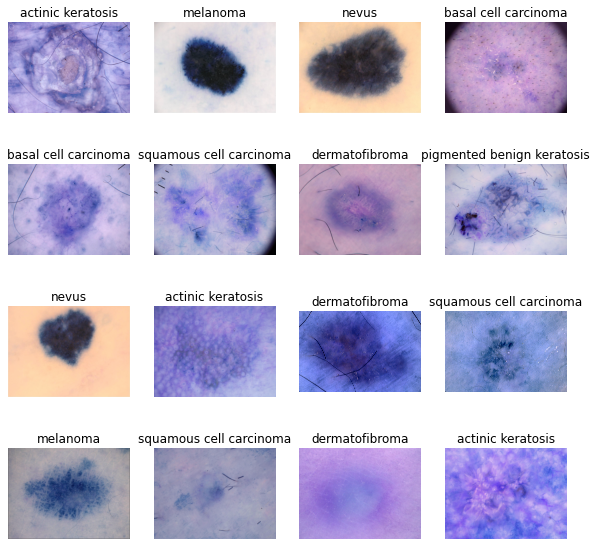

In [ ]:
plt.figure(figsize=(10, 10))
i=1
import random 
for (img_array, class_num) in test_data:
    ax = plt.subplot(4, 4, i)
    i=i+1
    plt.imshow(img_array)
    plt.title(class_num)
    plt.axis("off")
    if i==17 :
      break

# **V3**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
IMG_SHAPE = (224, 224,3)

In [ ]:
#datagen= ImageDataGenerateur(rescale=1.0/255)
pre_trained_model = InceptionV3(include_top=False,
                   input_shape=IMG_SHAPE,
                   pooling='avg',classes=2,
                   weights='imagenet')

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
pre_trained_model.trainable = False

In [ ]:
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :



In [ ]:
# Flatten the output layer to 1 dimension
x = Flatten ()(pre_trained_model.output)
# Ajouter une couche entièrement connectée avec 512 unités cachées et l'activation ReLU
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
# Ajouter une dernière couche sigmoïde pour la classification
x = layers.Dense(9, activation='softmax')(x)



In [ ]:
from keras.optimizers import RMSprop

In [ ]:
# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:

train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')


In [ ]:
train_datagen.fit(X_Train)

normalisation du données de validation :



In [ ]:
val_datagen = ImageDataGenerator()
val_datagen.fit(X_Val)

Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)



In [ ]:
history = model.fit(X_Train, Y_Train, batch_size=64, epochs=30,
                    validation_data=(X_Val, Y_Val))

Epoch 1/30
32/32 [==============================] - 18s 211ms/step - loss: 736259162112.0000 - accuracy: 0.1974 - val_loss: 2.1887 - val_accuracy: 0.1652
Epoch 2/30
32/32 [==============================] - 4s 132ms/step - loss: 2.1851 - accuracy: 0.2082 - val_loss: 2.1799 - val_accuracy: 0.1652
Epoch 3/30
32/32 [==============================] - 4s 133ms/step - loss: 2.1740 - accuracy: 0.2204 - val_loss: 2.1701 - val_accuracy: 0.1652
Epoch 4/30
32/32 [==============================] - 4s 132ms/step - loss: 2.1634 - accuracy: 0.2103 - val_loss: 2.1587 - val_accuracy: 0.1652
Epoch 5/30
32/32 [==============================] - 4s 133ms/step - loss: 2.1496 - accuracy: 0.2064 - val_loss: 2.1461 - val_accuracy: 0.1652
Epoch 6/30
32/32 [==============================] - 4s 134ms/step - loss: 2.1363 - accuracy: 0.2115 - val_loss: 2.1331 - val_accuracy: 0.1652
Epoch 7/30
32/32 [==============================] - 4s 134ms/step - loss: 2.1155 - accuracy: 0.2131 - val_loss: 2.1200 - val_accuracy: 0

# fine-tuning

In [ ]:
for layer in model.layers :
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
history1 = model.fit(X_Train, Y_Train, batch_size=64, epochs=30,
                    validation_data=(X_Val, Y_Val))

Epoch 1/30
32/32 [==============================] - 22s 476ms/step - loss: 2.0252 - acc: 0.2251 - val_loss: 2.0394 - val_acc: 0.1652
Epoch 2/30
32/32 [==============================] - 13s 422ms/step - loss: 2.0237 - acc: 0.2114 - val_loss: 2.0395 - val_acc: 0.1652
Epoch 3/30
32/32 [==============================] - 14s 423ms/step - loss: 2.0186 - acc: 0.2122 - val_loss: 2.0395 - val_acc: 0.1652
Epoch 4/30
32/32 [==============================] - 13s 418ms/step - loss: 1.9781 - acc: 0.2160 - val_loss: 2.0395 - val_acc: 0.1652
Epoch 5/30
32/32 [==============================] - 13s 414ms/step - loss: 2.0222 - acc: 0.1974 - val_loss: 2.0394 - val_acc: 0.1652
Epoch 6/30
32/32 [==============================] - 13s 414ms/step - loss: 2.0073 - acc: 0.2072 - val_loss: 2.0395 - val_acc: 0.1652
Epoch 7/30
32/32 [==============================] - 13s 416ms/step - loss: 2.0126 - acc: 0.2007 - val_loss: 2.0395 - val_acc: 0.1652
Epoch 8/30
32/32 [==============================] - 13s 418ms/step - 

In [ ]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 2s 66ms/step - loss: 2.0394 - acc: 0.1652
Validation: accuracy = 0.165179  ;  loss_v = 2.039437


In [ ]:
model.save("V3")

INFO:tensorflow:Assets written to: V3/assets


Text(0.5, 1.0, 'Training and validation loss')

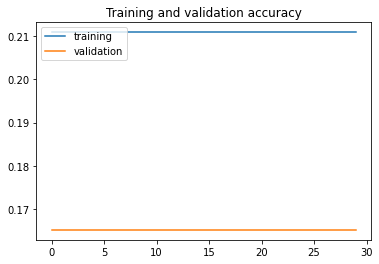

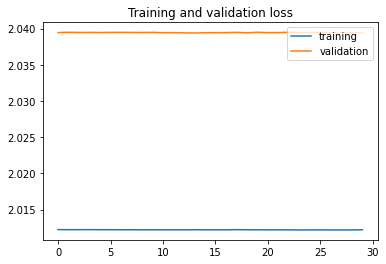

In [ ]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']


loss = history1.history['loss']
val_loss = history1.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')